<a href="https://colab.research.google.com/github/eisbetterthanpi/latent-flow-matching/blob/main/flow_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),) # do not normalise! want img in [0,1)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 128 # 64 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x)

In [3]:
# @title rope & RotEmb
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class RoPE(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, seq_len=512, base=10000):
        super().__init__()
        self.dim, self.base = dim, base
        theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
        pos = torch.arange(seq_len).unsqueeze(-1)
        angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, seq_len, dim // 2, 2] -> [1, seq_len, dim]

    def forward(self, x): # [batch, T, dim] / [batch, T, n_heads, d_head]
        seq_len = x.size(1)
        if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
        # print('rope fwd', x.shape, self.rot_emb.shape)
        if x.dim()==4: return x * self.rot_emb[:,:seq_len].unsqueeze(2)
        return x * self.rot_emb[:,:seq_len]

class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]

class RoPE2D(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, h=224, w=224, base=10000):
        super().__init__()
        self.dim, self.h, self.w = dim, h, w
        # # theta = 1. / (base ** (torch.arange(0, dim, step=4) / dim))
        # theta = 1. / (base**torch.linspace(0,1,dim//4)).unsqueeze(0)
        theta = 1. / (base**torch.linspace(0,1,dim//2)).unsqueeze(0)
        y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
        y, x = (y.reshape(-1,1) * theta).unsqueeze(-1), (x.reshape(-1,1) * theta).unsqueeze(-1) # [h*w,1]*[1,dim//4] = [h*w, dim//4, 1]
        # # self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).flatten(-2) # [h*w, dim//4 ,4] -> [h*w, dim]
        # self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
        self.rot_emb = torch.cat([x.sin(), y.sin()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
        # self.rot_emb = torch.cat([x.cos(), y.cos()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]

    def forward(self, img): #
        # batch, dim, h, w = img.shape
        # print(img.shape)
        hw = img.shape[1] # [b, hw, dim] / [b, hw, n_heads, d_head]
        h=w=int(hw**.5)
        if self.h < h or self.w < w: self.__init__(self.dim, h, w)
        # print(self.rot_emb.shape)
        # rot_emb = self.rot_emb[:, :h, :w].unsqueeze(0) # [1, h, w, dim]
        rot_emb = self.rot_emb[:h, :w] # [h, w, dim]
        # return img * rot_emb.flatten(end_dim=1).unsqueeze(0) # [b, hw, dim] * [1, hw, dim]
        return img * rot_emb.flatten(end_dim=1)[None,:,None,:] # [b, hw, n_heads, d_head] * [1, hw, 1, dim]
        # return img * self.rot_emb


# def RoPE2D(dim=16, h=8, w=8, base=10000):
#     # theta = 1. / (base ** (torch.arange(0, dim, step=4) / dim))
#     theta = 1. / (base**torch.linspace(0,1,dim//4)).unsqueeze(0)
#     y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
#     y, x = (y.reshape(-1,1) * theta).unsqueeze(-1), (x.reshape(-1,1) * theta).unsqueeze(-1) # [h*w,1]*[1,dim//4] = [h*w, dim//4, 1]
#     rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).flatten(-2) # [h*w, dim//4 ,4] -> [h*w, dim]
#     # rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1)#.reshape(dim, h, w).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
#     return rot_emb


# rotemb = RotEmb(10)
# seq_len=10
# pos = torch.linspace(0,1,seq_len).to(device)#.unsqueeze(-1)
# rot_emb = rotemb(pos)
# print(rot_emb)

In [6]:
# @title UpDownBlock
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        # self.res_conv = zero_module(nn.Conv2d(in_ch, out_ch, 1)) if in_ch != out_ch else nn.Identity()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), act, zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)),
            )

    def forward(self, x): # [b,c,h,w]
        return self.block(x) + self.res_conv(x)

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        if self.r>1: self.net = nn.Sequential(ResBlock(in_ch, out_ch*r**2), nn.PixelShuffle(r))
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), ResBlock(in_ch*r**2, out_ch))
        else: self.net = ResBlock(in_ch, out_ch)

    def forward(self, x):
        return self.net(x)

class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, r=1):
        super().__init__()
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)

    def forward(self, x): # [b,c,h,w]
        out = self.block(x)
        shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        return out + shortcut


In [37]:
# @title U-DiT me
# https://github.com/YuchuanTian/U-DiT/blob/main/udit_models.py
import torch
import torch.nn as nn
import torch.nn.functional as F


import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class LayerNorm2d(nn.RMSNorm): # LayerNorm RMSNorm
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, x): return super().forward(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads, r=2):
        super().__init__()
        self.dim, self.heads, self.r = dim, n_heads, r
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.lin = nn.Conv2d(dim, dim, 1)
        self.rope = RoPE(d_head, seq_len=512, base=10000)
        # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        self.scale = d_head**-.5

    def forward(self, x): # [b,c,h,w]
        b,c,h,w = x.shape
        x = x.flatten(2).transpose(-2,-1)

        q,k,v = self.qkv(x).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, n_heads, d_head]?
        q, k = self.rope(q), self.rope(k)

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [batch, n_heads, T/num_tok, d_head]

        x = x.transpose(-2,-1).reshape(b,c,h,w) # [batch, n_heads, T/num_tok, d_head] -> [batch, n_heads*d_head, T/num_tok] -> [b,c,h,w]
        return self.lin(x)

class U_DiTBlock(nn.Module):
    def __init__(self, d_model, cond_dim, n_heads, down_factor=2):
        super().__init__()
        self.d_model = d_model
        self.norm = LayerNorm2d(d_model, elementwise_affine=False)
        self.attn = SelfAttn(d_model, n_heads=n_heads, r=down_factor)
        self.adaLN_modulation = nn.Sequential(nn.SiLU(), zero_module(nn.Linear(cond_dim, 3*d_model))) # adaptive layer norm zero (adaLN-Zero). very important!

    def forward(self, x, cond):
        shift_msa, scale_msa, gate_msa = self.adaLN_modulation(cond)[...,None,None].chunk(3, dim=1) # [batch, d_model, 1, 1]
        x = x + gate_msa * self.attn((1 + scale_msa) * self.norm(x) + shift_msa)
        return x


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim=None, cond_dim=None, n_heads=None, d_head=8, depth=1, r=1):
        super().__init__()
        n_heads = n_heads or out_ch//d_head
        self.seq = Seq(
            UpDownBlock(in_ch, out_ch, r=min(1,r)) if in_ch != out_ch or r<1 else nn.Identity(),
            *[U_DiTBlock(out_ch, cond_dim, n_heads) for i in range(depth)],
            UpDownBlock(out_ch, out_ch, r=r) if r>1 else nn.Identity(),
        )

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class U_DiT(nn.Module):
    def __init__(self, in_ch=3, d_model=96, out_ch=None, emb_dim=None, cond_dim=16, depth=[2,5,8,5,2], n_heads=16, d_head=4):
        super().__init__()
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        emb_dim = emb_dim or d_model# * 4
        self.time_emb = nn.Sequential(RotEmb(d_model), nn.Linear(d_model, d_model), nn.SiLU(), nn.Linear(d_model, 3*emb_dim))
        self.cond_emb = nn.Linear(cond_dim, 3*d_model)
        self.in_block = nn.Conv2d(in_ch, d_model, 3, 1, 3//2)

        depth = 3
        # mult = [1,2,4,8] # [1,4,6,8]
        mult = [1,2,3,4] # [1,1,1,1] [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]

        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])
        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1/2) for i in range(depth-1)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1/4 if i==0 else 1/2) for i in range(depth-1)])
        emb_dim=None
        self.middle_block = Seq(
            UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2),
            U_DiTBlock(ch_list[depth], cond_dim=d_model, n_heads=d_model//d_head),
            UpDownBlock(ch_list[depth], ch_list[depth-1], r=2),
        )

        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=2) for i in reversed(range(depth-1))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=4 if i==0 else 2) for i in reversed(range(depth-1))])

        # # self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # # self.out = nn.Conv2d(d_model, out_ch, 3, padding = 3//2) # lucid; or prepend final res block
        self.skip_scale = nn.Parameter(torch.tensor(2**-.5))


    def forward(self, x, t, y): # [b,c,h,w], time [b], class label [b]
        c123 = self.time_emb(t) + self.cond_emb(y)
        cond = c123.chunk(3, dim=1)
        x = self.in_block(x)

        blocks = []
        for i, down in enumerate(self.down_list):
            # print('U_DiT down', x.shape)
            x = down(x, cond=cond[i])
            blocks.append(x)
        # print('U_DiT mid1', x.shape)
        x = self.middle_block(x, cond=cond[-1])
        # print('U_DiT mid2', x.shape)
        for i, up in enumerate(self.up_list):
            # print('U_DiT up', x.shape)
            # x = torch.cat([x, blocks[-i-1]*2**-.5], dim=1)
            # print(len(self.up_list)-i)
            x = torch.cat([x, blocks[-i-1]*self.skip_scale**(len(self.up_list)-i)], dim=1) # https://arxiv.org/pdf/2310.13545
            x = up(x, cond=cond[-1-i])
        return self.out(x)

# norm,act,zeroconv < finallyr
# attnblk =< uditblk(no down)?

# nope, posemb input, rope qk
# adaln, crossattn

# downattn decreases faster but plateaus
# no UpDownBlock?

# nomlp in uditblk
# updown downscale saves vram: 6->3gb

# def U_DiT_S(**kwargs): return U_DiT(down_factor=2, d_model=96, n_heads=4, depth=[2,5,8,5,2], mlp_ratio=2, downsampler='dwconv5', down_shortcut=1)
# def U_DiT_B:  U_DiT(d_model=192, n_heads=8,
# def U_DiT_L: U_DiT(d_model=384, n_heads=16,
in_ch=1
cond_dim=10
model = U_DiT(in_ch=in_ch, d_model=64, n_heads=4, depth=[1], cond_dim=cond_dim).to(device)
# model = U_DiT(in_ch=3, d_model=128, n_heads=4, depth=[1], cond_dim=cond_dim).to(device)
# for name, param in model.named_parameters(): print(name, param.numel())
# print(sum(p.numel() for p in model.down_list.parameters() if p.requires_grad)) # 19683
# print(sum(p.numel() for p in model.up_list.parameters() if p.requires_grad)) # 19683

batch=64
inputs = torch.rand((batch, in_ch, 32, 32), device=device)
# inputs = torch.rand((batch, in_ch, 64, 64), device=device)
t = torch.rand((batch), device=device)
y = torch.rand((batch, cond_dim), device=device)

out = model(inputs, t, y)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) #
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683


torch.Size([64, 1, 32, 32])
16972802


In [38]:
# @title LogitNormal
import torch
import torch.distributions as dist
import torch.nn.functional as F

class LogitNormal(dist.Distribution):
    def __init__(self, mu=0, std=.5):
        super().__init__()
        self.mu, self.std = mu, std
        self._normal = dist.Normal(mu, std) # https://pytorch.org/docs/stable/distributions.html#normal

    def rsample(self, sample_shape=torch.Size()):
        eps = self._normal.rsample(sample_shape)
        return torch.sigmoid(eps) # https://en.wikipedia.org/wiki/Logit-normal_distribution

logit_normal = LogitNormal()
# samples = logit_normal.rsample((10,))
# print(samples)


/usr/local/lib/python3.11/dist-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.LogitNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [39]:
# @title sampling timestep
# def InverseSigmoid(x): return torch.log(x/(1-x))
# def Normal(x, mu=0, std=.5): return torch.exp(-.5*((x-mu)/std)**2)/(std*(2*torch.pi)**2)
# def LogitNormalPDF(x, mu=0, std=.5): return torch.nan_to_num(Normal(logit(x), mu, std) * 1/(x*(1-x)))

# def invlogit(x): return torch.exp(x)/(1+torch.exp(x))
# def InvLogitNormalCDF(x, mu=0, std=.5):
#     cdf = invlogit(torch.erfinv(2*x-1)*(2**.5*std)+mu)
#     cdf[x==1.] = 1 # lol, replace nan with 1 when x=1
#     return cdf

def logit(x): return torch.log(x/(1-x)) # x in (0,1)
def LogitNormalCDF(x, mu=0, std=.5): # _/- for std<1.8; /-/ for std>1.8
    cdf = 1/2 * (1 + torch.erf((logit(x)-mu)/(2**.5*std)))
    return cdf

def Cosine(x): return .5*(-torch.cos(torch.pi*x)+1) # _/-
def Polynomial(x): return -2*x**3 + 3*x**2 # -2x^3 + 3x^2 # _/-
def ACosine(x): return torch.acos(1-2*x)/torch.pi # /-/ # x = acos(1-2y)/pi
def InvertCubic(x): return (x-1)**3+1 # /-
def InvertExp(x, a=4): return (1-torch.exp(-a*x)) / (1-torch.exp(torch.tensor(-a))) # /-


a, b = .0, 0
def bezier(t, x0=0,y0=0, x1=a,y1=b, x2=1-a,y2=1-b, x3=1,y3=1):
    # print(x1,y1)
    # return ((1-t)*((1-t)*((1-t)*x0+t*x1)+t*((1-t)*x1+t*x2))+t*((1-t)*((1-t)*x1+t*x2)+t*((1-t)*x2+t*x3)), (1-t)*((1-t)*((1-t)*y0+t*y1) +t*((1-t)*y1+t*y2))+t*((1-t)*((1-t)*y1+t*y2) +t*((1-t)*y2+t*y3)))
    return (1-t)*((1-t)*((1-t)*x0+t*x1)+t*((1-t)*x1+t*x2))+t*((1-t)*((1-t)*x1+t*x2)+t*((1-t)*x2+t*x3))
    # return (1-t)*((1-t)*((1-t)*y0+t*y1) +t*((1-t)*y1+t*y2))+t*((1-t)*((1-t)*y1+t*y2) +t*((1-t)*y2+t*y3))


# x = torch.linspace(0, 1, 30)
# y=x
# y = LogitNormalCDF(x, mu=0, std=3) # _/- for std<1.8; /-/ for std>1.8
# y = Cosine(x) # _/-
# y = ACosine(x) # /-/
# y = Polynomial(x) # _/-
# y = InvertCubic(x) # /-
# y = InvertExp(x) # /-
# y = bezier(x) # _/-
# print(x, y)
# import matplotlib.pyplot as plt
# plt.plot(x, y)
# plt.show()



In [40]:
# @title Sampling
import torchvision
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def reverse_flow(unet, cond, timesteps=25, img_shape=(1,32,32)): # [n_samples, cond_dim]
    training = unet.training
    unet.eval()
    i = torch.linspace(0, 1, timesteps+1)
    # y = i # linear
    # y = LogitNormalCDF(i, mu=0, std=3.) # .5 _/- for std<1.8; 3 /-/ for std>1.8
    y = LogitNormalCDF(i, mu=-.0, std=2.7) # .5 _/- for std<1.8; 3 /-/ for std>1.8
    # y = Cosine(i) # _/-
    # y = ACosine(i) # /-/
    # y = Polynomial(i) # _/-
    # y = InvertCubic(i) # /-
    # y = InvertExp(i) # /-
    # y = bezier(i) # _/-

    dt = y[1:]-y[:-1]
    num_samples = cond.shape[0]
    # x = torch.randn((num_samples, unet.in_ch, 16,16), device=device)
    # x = torch.randn((num_samples, 3, 64,64), device=device)
    x = torch.randn((num_samples, *img_shape), device=device)
    # cond = cond.repeat(num_samples,1) # [n_samples, cond_dim]
    for y, dt in zip(y, dt):
        # print(y, dt)
        t = torch.full((num_samples,), y, device=device)  # Current time # [num_samples] 1. # torch.tensor(i * dt, device=device).repeat(n_samples)
        with torch.no_grad():
            model = lambda y,t: -unet(y, t, cond)
            v = model(x, t)
            x = x - dt * v # Euler update # 25steps:1sec

            # k1 = model(x, t)
            # k2 = model(x - 0.5 * dt * k1, t - 0.5 * dt)
            # k3 = model(x - 0.5 * dt * k2, t - 0.5 * dt)
            # k4 = model(x - dt * k3, t - dt)
            # x = x - (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4) # RK4 update # 25steps:4.5sec
    if training: unet.train()
    return x


# # cond = F.one_hot(torch.tensor([3]*16, device=device), num_classes=10).to(torch.float)
# cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
# # img_ = reverse_flow(model, cond, timesteps=10)
# img_ = model.sample(cond)
# # # plt.imshow(img_.cpu().squeeze())
# # # plt.show()
# imshow(torchvision.utils.make_grid(img_.cpu(), nrow=4))


0 1.1453804969787598


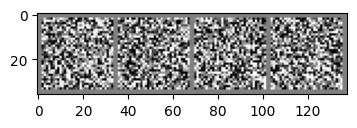

10 0.9140372276306152
20 0.5967540144920349
30 0.2707696855068207
40 0.1620214283466339
50 0.14127078652381897
60 0.1254006326198578
70 0.1154569685459137
80 0.10886931419372559
90 0.10190349817276001
100 0.10453899204730988
110 0.10752566158771515
120 0.09542183578014374
130 0.0990094244480133
140 0.09446550905704498
150 0.08874209225177765
160 0.08637696504592896
170 0.09016701579093933
180 0.09285558015108109
190 0.08591194450855255


200 0.08455280214548111


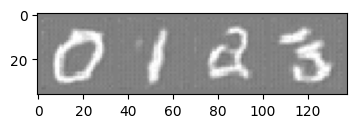

210 0.08658789098262787
220 0.08767469227313995
230 0.08601196855306625
240 0.08360575139522552
250 0.0783894881606102
260 0.0827406495809555
270 0.07676749676465988
280 0.08158543705940247
290 0.07832604646682739
300 0.0811883732676506
310 0.08011289685964584
320 0.07929947972297668
330 0.0779724270105362
340 0.08104074001312256
350 0.07805807888507843
360 0.07830417156219482
370 0.07647985219955444
380 0.08140312880277634
390 0.07380926609039307


400 0.08030113577842712


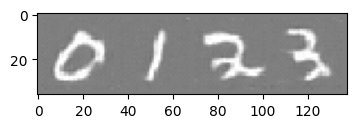

410 0.0781194344162941
420 0.07399234920740128
430 0.07705943286418915
440 0.07995429635047913
450 0.07166910171508789
460 0.07232104986906052


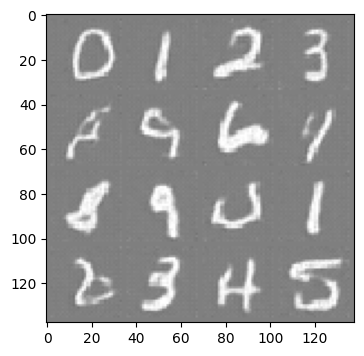

0 0.07518843561410904


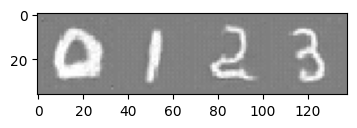

10 0.07630515098571777
20 0.07427938282489777
30 0.07343928515911102
40 0.07608824223279953
50 0.07486496865749359
60 0.07413990050554276
70 0.07337339967489243
80 0.07411602139472961
90 0.07094064354896545
100 0.07316738367080688
110 0.07429339736700058
120 0.07522358000278473
130 0.07384341955184937
140 0.0706605315208435
150 0.07414206117391586
160 0.07371826469898224
170 0.07335323095321655
180 0.07066228985786438
190 0.07450076937675476


200 0.07292196154594421


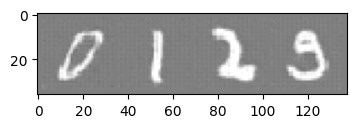

210 0.07082773000001907
220 0.07253243029117584
230 0.07086750119924545
240 0.07446898519992828
250 0.06882307678461075
260 0.07233315706253052
270 0.07221482694149017
280 0.06925509870052338
290 0.07233374565839767
300 0.07468434423208237
310 0.07253246009349823
320 0.07094057649374008
330 0.06919936835765839
340 0.07428523898124695
350 0.0688675045967102
360 0.07375013828277588
370 0.07151390612125397
380 0.07213981449604034
390 0.07212090492248535


400 0.0714847594499588


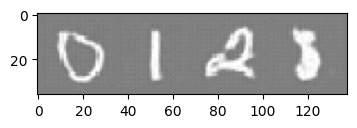

410 0.07451508939266205
420 0.06952089071273804
430 0.07619956880807877
440 0.07246653735637665
450 0.07603514194488525
460 0.07476001977920532


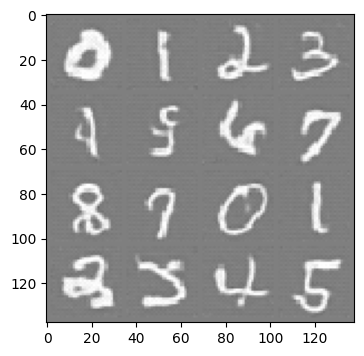

In [42]:
# @title train
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler(device)

def otfm_loss(model, x1, cond, sig_min = 0.001, eps = 1e-5): # UNetModel, [b,c,h,w], [b,cond_dim] # https://github.com/lebellig/flow-matching/blob/main/Flow_Matching.ipynb
    batch = x1.size(0)
    # t = torch.rand((batch,), device=device) % (1 - eps)
    t = logit_normal.rsample((batch,)).to(device) # in [0,1] [batch,1]
    t_ = t[...,None,None,None]
    x0 = torch.randn_like(x1)
    psi_t = (1 - (1-sig_min)*t_)*x0 + t_*x1 # ψt(x) = (1 − (1 − σmin)t)x + tx1, (22)
    v_psi = model(psi_t, t, cond) # vt(ψt(x0))
    d_psi = x1 - (1 - sig_min) * x0 #
    return F.mse_loss(v_psi, d_psi) # LCFM(θ)

def train(model, optim, dataloader):
    model.train()
    for i, (x1, y) in enumerate(dataloader):
        x1, y = x1.to(device), y.to(device)
        cond = F.one_hot(y, num_classes=10).to(torch.float)
        # img = F.interpolate(x1, size=(16,16)).repeat(1,3,1,1)
        img = F.interpolate(x1, size=(32,32))
        # img = F.interpolate(x1, size=(64,64)).repeat(1,3,1,1)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?
            loss = otfm_loss(model, img, cond)

        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
        scaler.step(optim)
        scaler.update()

        if i % 10 == 0:
            print(i,loss.item())
            # print(i,ae_loss.item(), fm_loss.item())
        if i % 200 == 0:
            with torch.no_grad():
                cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
                img_ = reverse_flow(model, cond, timesteps=10) # unet
                imshow(torchvision.utils.make_grid(img_[:4].cpu(), nrow=4))

        try: wandb.log({"loss": loss.item()})
        # try: wandb.log({"ae_loss": ae_loss.item(), "fm_loss": fm_loss.item()})
        except NameError: pass

for epoch in range(2):
    train(model, optim, train_loader)

    model.eval()
    with torch.no_grad():
        cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
        img_ = reverse_flow(model, cond, timesteps=10) # unet
        imshow(torchvision.utils.make_grid(img_.cpu(), nrow=4))


In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="lfm", config={"model": "res18",})

In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

# modelsd, optimsd = torch.load(folder+'lfm.pkl', map_location=device).values()
# model.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)

In [ ]:
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, folder+'lfm.pkl')